In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import models
import utils
import scipy.signal

In [2]:
file_name  = "take-five"
audio_file = f"{file_name}.wav"
midi_file  = f"{file_name}.mid"
waveform, sample_rate = torchaudio.load(audio_file)

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = waveform.squeeze(0)

## Getting the spectrogram

In [3]:
n_fft           = 1024
hop_length      = 512
min_mag         = 1e-5

spec_db, spec_np, times, frequencies = utils.spectrogram(waveform, sample_rate, n_fft, hop_length, min_mag)
spec_db_cqt, times_cqt, frequencies_cqt = utils.cqt_spec(waveform, sample_rate, hop_length)

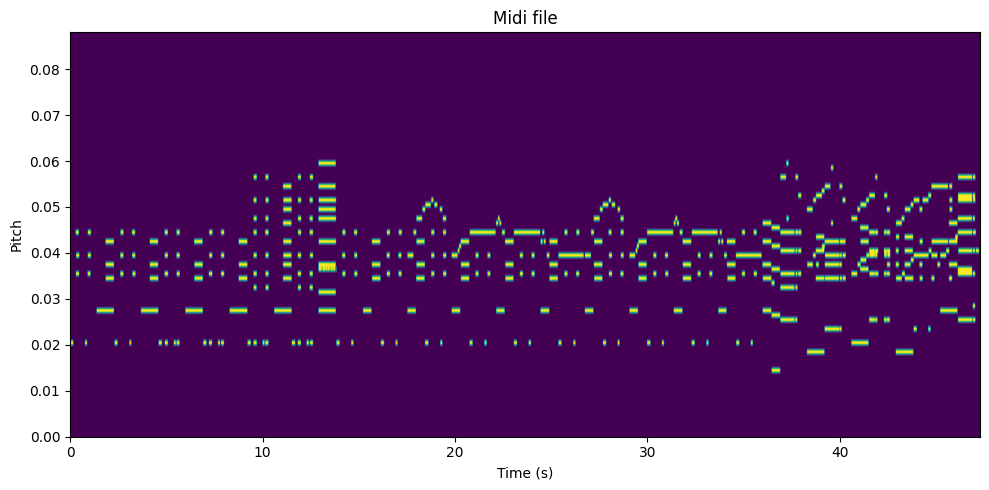

In [5]:
midi = utils.midi_to_pianoroll(midi_file, spec_db.shape[1], hop_length, sample_rate)
utils.vis_midi(midi, times, 0, times[-1])

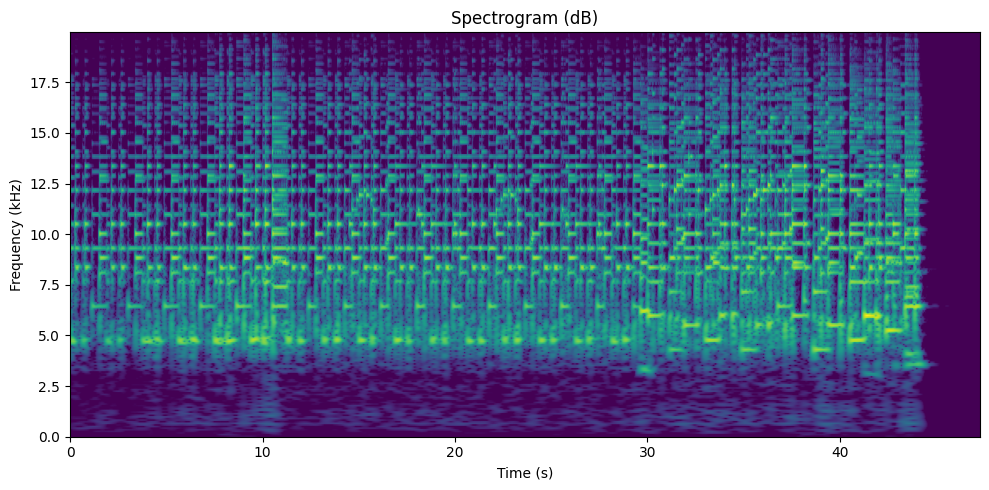

In [7]:
start = 0
stop  = times[-1]

min_freq = 0
max_freq = 20*1e3

utils.vis_spectrogram(spec_db_cqt, times, frequencies, start, stop, min_freq, max_freq)

Folding over in the 22-25 kHz range due to the sample rate (48kHz)

$\to$ Applying a lowpass filter to attenuate it (attenuate everything over $\frac{sample\_rate}{2}$)

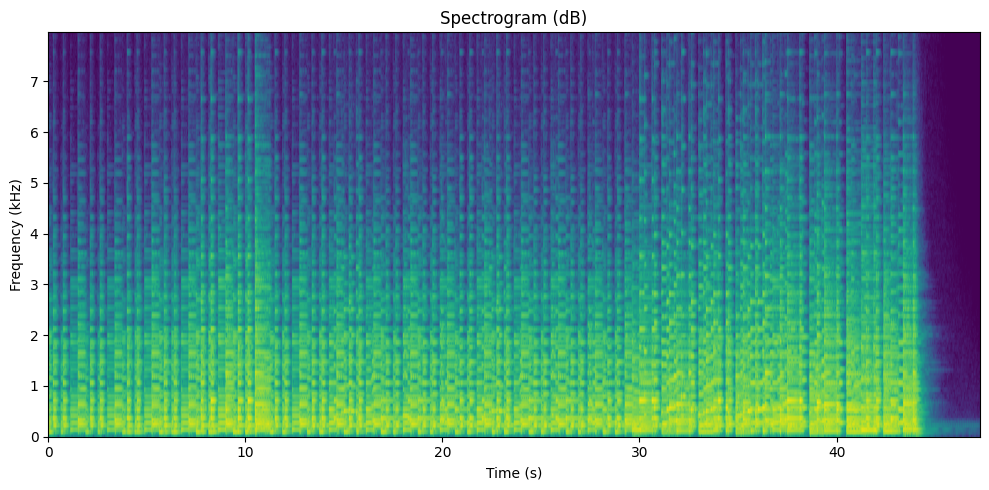

In [7]:
cutoff_freq = 21000
nyquist_rate = sample_rate / 2
normalized_cutoff = cutoff_freq / nyquist_rate
order = 4
b, a = scipy.signal.butter(order, normalized_cutoff, btype='low')
filtered_waveform = torch.tensor(scipy.signal.lfilter(b, a, waveform.numpy(), axis=-1))

filtered_spec_db, filtered_spec_np, times, frequencies = utils.spectrogram(filtered_waveform, sample_rate, n_fft, hop_length, min_mag)
utils.vis_spectrogram(filtered_spec_np, times, frequencies, start, stop, min_freq, max_freq)

## Unrolled NMF

M ≈ WH 

**M** : spectrogram (`spec_db`), **W** : dictionnary of notes, **H** : notes activations, **l** : number of different notes to detect

In [20]:
# Init
M       = spec_db[:250,:900]
l       = 88
f       = M.shape[0]
t       = M.shape[1]
n_iter  = 5

In [9]:
print(f"input spectrogram: {M.shape}")
print(f"number of notes to be split: {l}")
print(f"number of frequency bins: {f}")
print(f"number of time bins: {t}")

input spectrogram: torch.Size([250, 900])
number of notes to be split: 88
number of frequency bins: 250
number of time bins: 900


### Iterative MU

In [10]:
# W, H, M_hat = models.MU_iter(M, l, f, t, n_iter)

### Unrolled RALMU

In [21]:
eps     = 1e-5
alpha   = 0.1
model   = models.RALMU(f, t, l, n_iter, shared=True, eps=eps, alpha=alpha)
device  = torch.device('cpu')
model.to(device=device)

RALMU(
  (layers): ModuleList(
    (0-4): 5 x RALMU_block2(
      (Aw): Aw(
        (fc0): Linear(in_features=22000, out_features=130, bias=True)
        (fc1): Linear(in_features=130, out_features=75, bias=True)
        (fc2): Linear(in_features=75, out_features=22000, bias=True)
        (relu): ReLU()
      )
      (Ah): Ah(
        (fc0): Linear(in_features=79200, out_features=130, bias=True)
        (fc1): Linear(in_features=130, out_features=75, bias=True)
        (fc2): Linear(in_features=75, out_features=79200, bias=True)
        (relu): ReLU()
      )
    )
  )
)

- **Load** the dataset

In [17]:
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

- **Train** the model

In [18]:
n_epochs    = 20
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-5)

Epoch 1, Loss: 2980644096.0000
Grad norm: 0.06572013348340988
Grad norm: 0.040950000286102295
Grad norm: 0.7175804376602173
Grad norm: 0.010298068635165691
Grad norm: 0.05939331650733948
Grad norm: 0.02480027638375759
Grad norm: 0.03880640119314194
Grad norm: 0.06725072115659714
Grad norm: 0.6438305377960205
Grad norm: 0.03968748822808266
Grad norm: 0.021289674565196037
Grad norm: 0.0852261483669281
Grad norm: 0.0702715516090393
Grad norm: 0.2003539800643921
Epoch 2, Loss: 2980644096.0000
Grad norm: 0.06572013348340988
Grad norm: 0.040950000286102295
Grad norm: 0.7175804376602173
Grad norm: 0.010298068635165691
Grad norm: 0.05939331650733948
Grad norm: 0.02480027638375759
Grad norm: 0.03880640119314194
Grad norm: 0.06725072115659714
Grad norm: 0.6438305377960205
Grad norm: 0.03968748822808266
Grad norm: 0.021289674565196037
Grad norm: 0.0852261483669281
Grad norm: 0.0702715516090393
Grad norm: 0.2003539800643921
Epoch 3, Loss: 2980644096.0000
Grad norm: 0.06572013348340988
Grad norm: 0

Text(0.5, 0, 'Epochs')

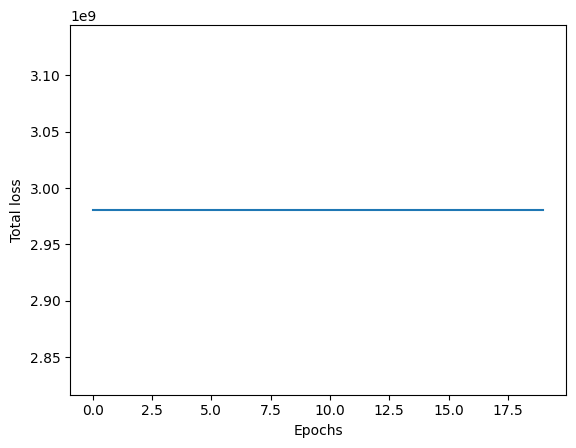

In [22]:
loss = utils.train(n_epochs, model, optimizer, loader, device)


plt.plot(loss)
plt.ylabel("Total loss")
plt.xlabel("Epochs")